# Cookie cutter

The aim of this notebook is to produce summary statistics for Hazards over NCRA regions, with the flexibility to apply the method to any shapefile region.

Typical statistics include median, mean, min, max, 10th, 90th percentiles

This method has used guidance from [https://github.com/aus-ref-clim-data-nci/shapefiles/blob/master/python_tutorial.ipynb]

## Step 1 - access needed packages

In [1]:
# navigate to correct working directory

In [2]:
cd /g/data/mn51/users/gt3409/plotting_maps/

/g/data/mn51/users/gt3409/plotting_maps


In [3]:
# import needed packages
from acs_area_statistics import acs_regional_stats, get_regions
import xarray as xr

In [4]:
import geopandas as gpd
from glob import glob
import pandas as pd
import regionmask
PATH = "/g/data/ia39/aus-ref-clim-data-nci/shapefiles/data"
import matplotlib.pyplot as plt

In [5]:
get_regions?

Signature: get_regions(shapefiles)
Docstring:
This function takes a list of names of shape files from ia39 and
returns a combined regionmask.

Parameters
-----------
name: str
    one of "aus_local_gov", "aus_states_territories", "australia", 
    "nrm_regions", "ncra_regions","broadacre_regions",
    "NCRA_regions_coastal_waters_GDA94"

Returns
-------
geopandas dataframe
File:      /g/data/mn51/users/gt3409/plotting_maps/acs_area_statistics.py
Type:      function

In [6]:
# NCRA regions from acs_area_statistics code
# these are the names of your regions
regions = get_regions([
                          "nrm_regions", "australia"
                      ])
regions

<regionmask.Regions 'nrm_regions-australia'>
overlap:  True

Regions:
 0   WT                Wet Tropics
 1   RN         Rangelands (North)
 2  MNE     Monsoonal North (East)
 3  MNW     Monsoonal North (West)
 4  ECS         East Coast (South)
..  ...                        ...
11 SSTE Southern Slopes (Tas East)
12 SSTW Southern Slopes (Tas West)
13  ECN         East Coast (North)
14   RS         Rangelands (South)
15  AUS                  Australia

[16 regions]

## Step 2 - Load and prepare data

Open the data you need.

Optional: You may need to perform some selection or summary from your data. 

Optional: You may like to visualise your data t understand it a bit better.


In [7]:
%%time 
# open Hazard data
# this is a slowish part of the code. It is likely to be reused if you're interested in calculating multiple statistics
filename = "/g/data/ia39/ncra/bushfire/fire_climate_classes_AGCD-05i_MM_ssp370_v1-r1-ACS-NRNBC_GWL12.nc"
ds = xr.open_dataset(filename, use_cftime = True,)
ds

CPU times: user 3.42 s, sys: 1.48 s, total: 4.9 s
Wall time: 7.5 s


<xarray.Dataset> Size: 5MB
Dimensions:                      (lat: 691, lon: 886, class: 5)
Coordinates:
  * lat                          (lat) float64 6kB -44.5 -44.45 ... -10.05 -10.0
  * lon                          (lon) float64 7kB 112.0 112.0 ... 156.2 156.2
    clim_period                  <U6 24B ...
  * class                        (class) int64 40B 0 1 2 3 4
Data variables:
    fire_climate_class           (lat, lon) float64 5MB ...
    class_code                   (class) int64 40B ...
    class_long_description       (class) <U23 460B ...
    stern_dehoedt_minor_classes  (class) <U50 1kB ...
    colour_map                   (class) <U7 140B ...
Attributes: (12/13)
    data_source:                  BARPA ia39
    notebook:                     stern_dehoedt_ernst_2000_BARPA.ipynb
    Global_Warming_Level:         GWL1.2
    reference:                    Stern, H., De Hoedt, G., & Ernst, J. (2000)...
    GCM_model:                    EC-Earth3, CESM2, ACCESS-CM2, CMCC-ESM2, CN...
    Experiment_ID:                ssp370, ssp370, ssp370, ssp370, ssp370, ssp...
    ...                           ...
    RCM_model:                    CCAM-v2203-SN, CCAM-v2203-SN, CCAM-v2203-SN...
    RCM_model_version_ID:         v1-r1-ACS-MRNBC-AGCD-1960-2022, v1-r1-ACS-M...
    start_year:                   2004, 2010, 2010, 2012, 2016, 2015, 2011, 2...
    end_year:                     2023, 2029, 2029, 2031, 2035, 2034, 2030, 2...
    GWL:                          GWL1.2
    bias_correction_description:  MRNBC-AGCD

In [8]:
# optional
# prepare the data, eg maybe you want to select data over smaller range
# here we modify the data coordinate names to read as we expect
# ds = ds.rename({"latitude":"lat", "longitude":"lon"})
# fix float rounding errors
# ds = ds.assign_coords({"lat":ds.lat.astype("double").round(2), "lon":ds.lon.astype("double").round(2)})
ds

<xarray.Dataset> Size: 5MB
Dimensions:                      (lat: 691, lon: 886, class: 5)
Coordinates:
  * lat                          (lat) float64 6kB -44.5 -44.45 ... -10.05 -10.0
  * lon                          (lon) float64 7kB 112.0 112.0 ... 156.2 156.2
    clim_period                  <U6 24B ...
  * class                        (class) int64 40B 0 1 2 3 4
Data variables:
    fire_climate_class           (lat, lon) float64 5MB ...
    class_code                   (class) int64 40B ...
    class_long_description       (class) <U23 460B ...
    stern_dehoedt_minor_classes  (class) <U50 1kB ...
    colour_map                   (class) <U7 140B ...
Attributes: (12/13)
    data_source:                  BARPA ia39
    notebook:                     stern_dehoedt_ernst_2000_BARPA.ipynb
    Global_Warming_Level:         GWL1.2
    reference:                    Stern, H., De Hoedt, G., & Ernst, J. (2000)...
    GCM_model:                    EC-Earth3, CESM2, ACCESS-CM2, CMCC-ESM2, CN...
    Experiment_ID:                ssp370, ssp370, ssp370, ssp370, ssp370, ssp...
    ...                           ...
    RCM_model:                    CCAM-v2203-SN, CCAM-v2203-SN, CCAM-v2203-SN...
    RCM_model_version_ID:         v1-r1-ACS-MRNBC-AGCD-1960-2022, v1-r1-ACS-M...
    start_year:                   2004, 2010, 2010, 2012, 2016, 2015, 2011, 2...
    end_year:                     2023, 2029, 2029, 2031, 2035, 2034, 2030, 2...
    GWL:                          GWL1.2
    bias_correction_description:  MRNBC-AGCD

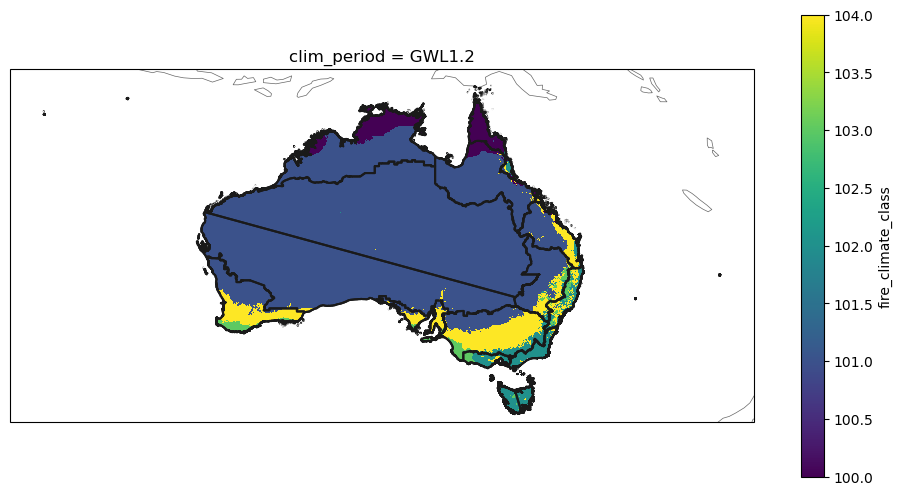

In [9]:
# optional 
# plot if you want to have a look at your data

var = "fire_climate_class"
fig = plt.figure(figsize=(12,6))

regions.plot(add_label=False)
ds[var].plot()

## Step 3 - Create your mask

There's a range of ways to calculate your mask:
- **regions.mask_3D(ds)** will create a "mask" array that is ```True``` for all grid cells whose centre point falls within a particular state/territory and ```False``` elsewhere
- **regions.mask_3D_frac_approx(ds)** will calculate the fraction of each grid cell that overlaps with each shape
- **mask_10pct** you may create a mask from the fraction values we need to decide on a minimum overlap threshold. eg ```mask_10pct = regions.mask_3D_frac_approx(ds) >= 0.1```

Fractional masking```regions.mask_3D_frac_approx(ds)``` which will weigh each lat lon grid by the approximate fraction of the area that lay within the shapefile geometery. It  is probably the most accurate, but more expensive than the simple mask_3D.

The masking methods return an xr.DataArray with three dimensions:  **region**, **lat**, and **lon**.

In [10]:
# create your mask
# You can also use a keyword for the function to calculate the mask,
# but if you're performing multiple calculations, this can be slow.

In [6]:
%%time
# if you're using AGCD-05i gridded data and one of the standard regions, 
# you can read in the precalculated masks to save time
mask_frac = xr.open_dataset("/g/data/ia39/aus-ref-clim-data-nci/shapefiles/masks/AGCD-05i/mask-3D_ncra-regions.nc")["mask"]


CPU times: user 18.7 ms, sys: 8.42 ms, total: 27.2 ms
Wall time: 23.6 ms


In [11]:
%%time
# calculate weighted mask this is a very slow part of the code and
# can be reused for any datasets using the same regions and the same lat lon
mask_frac = regions.mask_3D_frac_approx(ds[var])

CPU times: user 14.9 s, sys: 1.77 s, total: 16.7 s
Wall time: 16.6 s


In [12]:
regions

<regionmask.Regions 'nrm_regions-australia'>
overlap:  True

Regions:
 0   WT                Wet Tropics
 1   RN         Rangelands (North)
 2  MNE     Monsoonal North (East)
 3  MNW     Monsoonal North (West)
 4  ECS         East Coast (South)
..  ...                        ...
11 SSTE Southern Slopes (Tas East)
12 SSTW Southern Slopes (Tas West)
13  ECN         East Coast (North)
14   RS         Rangelands (South)
15  AUS                  Australia

[16 regions]

In [13]:
mask_centre = regions.mask_3D(ds)

## Step 4: Use function
To apply mask calculate a statistic to summarise each region 

In [14]:
# calculate the stats using the acs_region_fractional_stats function
# Find the stats for each region

dims = ("lat", "lon",)
df_summary = acs_regional_stats(ds=ds,var=var, mask=mask_frac, dims = dims, how = ["min", "median", "max"])


In [15]:
df_summary

<xarray.Dataset> Size: 4kB
Dimensions:                    (region: 16)
Coordinates:
    clim_period                <U6 24B 'GWL1.2'
  * region                     (region) int64 128B 0 1 2 3 4 ... 11 12 13 14 15
    abbrevs                    (region) <U5 320B 'WT' 'RN' 'MNE' ... 'RS' 'AUS'
    names                      (region) <U43 3kB 'Wet Tropics' ... 'Australia'
Data variables:
    fire_climate_class_min     (region) float64 128B 100.0 101.0 ... 101.0 100.0
    fire_climate_class_median  (region) float64 128B 100.0 101.0 ... 101.0 101.0
    fire_climate_class_max     (region) float64 128B 104.0 104.0 ... 104.0 104.0

In [16]:
# use with different mask
dims = ("lat", "lon",)
acs_regional_stats(ds=ds,var=var, mask=mask_centre, dims = dims, how = ["min", "median", "max", "mode", "proportions"])


<xarray.Dataset> Size: 4kB
Dimensions:                         (region: 16)
Coordinates:
    clim_period                     <U6 24B 'GWL1.2'
  * region                          (region) int64 128B 0 1 2 3 ... 12 13 14 15
    abbrevs                         (region) <U5 320B 'WT' 'RN' ... 'RS' 'AUS'
    names                           (region) <U43 3kB 'Wet Tropics' ... 'Aust...
Data variables:
    fire_climate_class_min          (region) float64 128B 100.0 101.0 ... 100.0
    fire_climate_class_median       (region) float64 128B 100.0 101.0 ... 101.0
    fire_climate_class_max          (region) float64 128B 104.0 104.0 ... 104.0
    fire_climate_class_mode         (region) float64 128B 100.0 101.0 ... 101.0
    fire_climate_class_proportions  (region) object 128B {100.0: 0.8458, 102....